In [3]:
import yfinance as yf 
import pandas as pd

In [4]:
# Read data
df = yf.download("BTC-USD")
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [5]:
df=df.filter(['Adj Close'])
df.shape

(3199, 1)

C:\Users\nptu\AppData\Local\Temp\ipykernel_20200\4151046076.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


<function matplotlib.pyplot.show(close=None, block=None)>

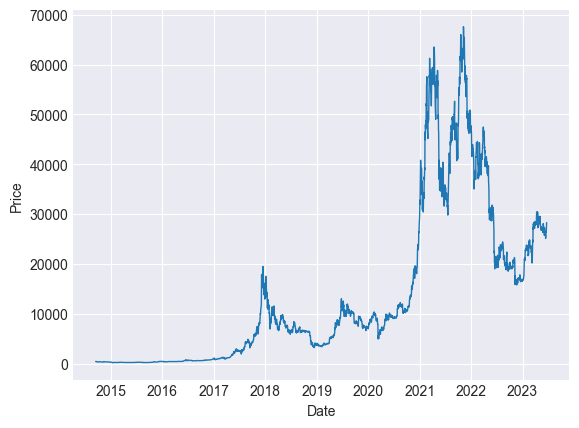

In [6]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df['Adj Close'],linewidth=1)
plt.show

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))  
scaler_price=scaler.fit_transform(df.values)

scaler_price


array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.38816745],
       [0.39580696],
       [0.41717798]])

In [8]:
import numpy as np
MOVING_WIN_SIZE = 60 # days
all_x, all_y =[], []
for i in range(len(scaler_price) - MOVING_WIN_SIZE):
    x = scaler_price[i:i+MOVING_WIN_SIZE]
    y = scaler_price[i+MOVING_WIN_SIZE]
    all_x.append(x)
    all_y.append(y)
all_x, all_y = np.array(all_x),np.array(all_y)

In [9]:
DS_SPLIT = 0.8
train_ds_size = round(all_x.shape[0] * DS_SPLIT)
train_x, train_y = all_x[:train_ds_size], all_y[:train_ds_size]
test_x, test_y = all_x[train_ds_size:], all_y[train_ds_size: ]

In [10]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
model = Sequential()
model. add(LSTM(units=50, return_sequences=True,input_shape=(train_x.shape[1],1)))
model. add(LSTM(units=50, return_sequences=False))
model. add (Dense (units=25))
model. add (Dense(units=1))
model.summary ()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor="val_loss",patience=10, restore_best_weights=True)
model.fit(train_x, train_y,
    validation_split=0.2,
    callbacks=[callback],
    epochs=1000)

Epoch 1/1000
63/63 [==============================] - 5s 36ms/step - loss: 7.0702e-04 - val_loss: 0.0026
Epoch 2/1000
63/63 [==============================] - 2s 27ms/step - loss: 1.1649e-04 - val_loss: 0.0024
Epoch 3/1000
63/63 [==============================] - 2s 28ms/step - loss: 9.1325e-05 - val_loss: 0.0056
Epoch 4/1000
63/63 [==============================] - 2s 28ms/step - loss: 8.6225e-05 - val_loss: 0.0060
Epoch 5/1000
63/63 [==============================] - 2s 28ms/step - loss: 7.0834e-05 - val_loss: 0.0124
Epoch 6/1000
63/63 [==============================] - 2s 27ms/step - loss: 7.3739e-05 - val_loss: 0.0062
Epoch 7/1000
63/63 [==============================] - 2s 29ms/step - loss: 6.8950e-05 - val_loss: 0.0071
Epoch 8/1000
63/63 [==============================] - 2s 28ms/step - loss: 5.7207e-05 - val_loss: 0.0124
Epoch 9/1000
63/63 [==============================] - 2s 28ms/step - loss: 5.9306e-05 - val_loss: 0.0125
Epoch 10/1000
63/63 [==============================] - 

In [13]:
preds = model.predict(test_x)
preds = scaler.inverse_transform(preds)

train_df = df[:train_ds_size+MOVING_WIN_SIZE]
test_df = df[train_ds_size+MOVING_WIN_SIZE: ]
test_df = test_df.assign(Predict=preds)

test_df= test_df.assign(Shifted=test_df["Adj Close"].shift(1))
test_df.iat[0, -1] = train_df.iat[-1, -1]
test_df

20/20 [==============================] - 1s 10ms/step


,Adj Close,Predict,Shifted
Date,,,
2021-10-01,48116.941406,41816.339844,43790.894531
2021-10-02,47711.488281,41936.738281,48116.941406
2021-10-03,48199.953125,42232.636719,47711.488281
2021-10-04,49112.902344,42652.109375,48199.953125
2021-10-05,51514.812500,43173.699219,49112.902344
...,...,...,...
2023-06-16,26327.462891,26291.599609,25576.394531
2023-06-17,26510.675781,26215.919922,26327.462891
2023-06-18,26336.212891,26186.142578,26510.675781


In [14]:
from sklearn.metrics import mean_squared_error
predict_rmse = mean_squared_error(test_df["Adj Close"], test_df["Predict"], squared=False)
predict_cvrmse=predict_rmse / test_df["Adj Close"].mean() *100
predict_cvrmse

8.42160098808641

In [81]:
shifted_rmse = mean_squared_error(test_df["Adj Close"], test_df["Shifted"], squared=False)
shifted_cvrmse = shifted_rmse / test_df[ "Adj Close" ].mean() * 100
shifted_cvrmse

3.481743592604733